# GridWorld Problem

In [36]:
using Plots
using ProgressBars

In [37]:
import ReinforcementLearning.FiniteMarkovDecisionProcesses as MDP

## Problem setup

In [38]:
next_states = [
    # 1 (up)  2 (down)  3 (right)  4 (left) 
      1       5         2         15         #  1
      2       6         3          1         #  2 
      3       7         3          2         #  3
     15       8         5          4         #  4
      1       9         6          4         #  5
      2      10         7          5         #  6
      3      11         7          6         #  7
      4      12         9          8         #  8
      5      13        10          8         #  9
      6      14        11          9         # 10
      7      15        11         10         # 11
      8      12        13         12         # 12
      9      13        14         12         # 13
     10      14        15         13         # 14
     15      15        15         15         # 15
]

rewards = -1*ones(size(next_states))
rewards[15, :] .= 0

fmdp = MDP.DeterministicFiniteMDP((s, a) -> next_states[s, a], (s, a) -> rewards[s, a], 4, 15, 15);

In [39]:
uniform_random_policy = 0.25 * ones(size(next_states)...)
V_uniform_random_policy = [-14.0, -20.0, -22.0, -14.0, -18.0, -20.0, -20.0, -20.0, -20.0, -18.0, -14.0, -22.0, -20.0, -14.0, 0.0];

random_deterministic_policy = rand(1:4, size(next_states, 1));

In [40]:
optimal_V = [-1.0, -2.0, -3.0, -1.0, -2.0, -3.0, -2.0, -2.0, -3.0, -2.0, -1.0, -3.0, -2.0, -1.0, 0.0];

## Some Handy Utilities

In [41]:
function V_to_matrix_form(V)
    VV = Matrix{Float64}(undef, 4, 4)
    VV[1,1] = V[15]
    for i = 1:14
        k = div(i,4)
        ℓ = rem(i,4)
        VV[k+1, ℓ+1] = V[i]
    end
    VV[4,4] = VV[1,1]
    return VV
end

V_test = 1:15
V_to_matrix_form(V_test)

4×4 Matrix{Float64}:
 15.0   1.0   2.0   3.0
  4.0   5.0   6.0   7.0
  8.0   9.0  10.0  11.0
 12.0  13.0  14.0  15.0

In [42]:
function action_to_char(a::Integer)
    if a == 1 # up
        return '↑'
    elseif a == 2 # down
        return '↓'
    elseif a == 3 # right
        return '→'
    elseif a == 4 # left
        return '←'
    else
        return '?'
    end
end

action_to_char (generic function with 2 methods)

In [43]:
function 𝐩_to_matrix_form(𝐩)
    PP = Matrix{Char}(undef, 4, 4)
    PP[1,1] = '█'
    for i = 1:14
        k = div(i,4)
        ℓ = rem(i,4)
        PP[k+1, ℓ+1] = action_to_char(𝐩[i])
    end
    PP[4,4] = '█'
    return PP
end

𝐩_to_matrix_form(random_deterministic_policy)

4×4 Matrix{Char}:
 '█'  '↓'  '←'  '↑'
 '→'  '↓'  '→'  '→'
 '↓'  '→'  '→'  '↓'
 '→'  '←'  '↓'  '█'

In [44]:
function action_probabilities_to_char(𝕡::AbstractVector{<:Real})
    vert = ' '
    if 𝕡[1] > 0 && 𝕡[2] > 0 # both UP and DOWN are valid
        vert = '↕'
    elseif 𝕡[1] > 0 # only UP is valid
        vert = '↑'
    elseif 𝕡[2] > 0 # only DOWN is valid
        vert = '↓'
    end
    horz = ' '
    if 𝕡[3] > 0 && 𝕡[4] > 0 # both RIGHT and LEFT are valid
        horz = '↔'
    elseif 𝕡[3] > 0 # only RIGHT is valid
        horz = '→'
    elseif 𝕡[4] > 0 # only LEFT is valid
        horz = '←'
    end
    return "$vert$horz"
end

action_probabilities_to_char (generic function with 2 methods)

In [45]:
function 𝐏_to_matrix_form(𝐏)
    PP = Matrix{String}(undef, 4, 4)
    PP[1,1] ="█"
    for i = 1:14
        k = div(i,4)
        ℓ = rem(i,4)
        PP[k+1, ℓ+1] = action_probabilities_to_char(𝐏[i,:])
    end
    PP[4,4] = "█"
    return PP
end

𝐏_to_matrix_form(uniform_random_policy)

4×4 Matrix{String}:
 "█"   "↕↔"  "↕↔"  "↕↔"
 "↕↔"  "↕↔"  "↕↔"  "↕↔"
 "↕↔"  "↕↔"  "↕↔"  "↕↔"
 "↕↔"  "↕↔"  "↕↔"  "█"

In [46]:
function find_errors_in_policy(𝐩::AbstractVector{<:Integer}, 𝐏::AbstractMatrix{<:Real})
    errors = []
    for s in 1:length(𝐩)-1
        if 𝐏[s, 𝐩[s]] == 0
            push!(errors, s)
        end
    end
    return errors
end

find_errors_in_policy (generic function with 1 method)

In [47]:
function error_symbol(ch)
    if ch == '↑'
        return '⍐'
    elseif ch == '↓'
        return '⍗'
    elseif ch == '→'
        return '⍈'
    elseif ch == '←'
        return '⍇'
    else
        return ' '
    end
end

function 𝐩_to_matrix_form_with_errors(𝐩, 𝐏)
    PP = 𝐩_to_matrix_form(𝐩)
    errors = find_errors_in_policy(𝐩, 𝐏)
    for err in errors
        k = div(err, 4)
        ℓ = rem(err, 4)
        PP[k+1, ℓ+1] = error_symbol(PP[k+1, ℓ+1])
    end
    return PP
end

𝐏 = zeros(15, 4)
𝐩_to_matrix_form_with_errors(random_deterministic_policy, 𝐏)

4×4 Matrix{Char}:
 '█'  '⍗'  '⍇'  '⍐'
 '⍈'  '⍗'  '⍈'  '⍈'
 '⍗'  '⍈'  '⍈'  '⍗'
 '⍈'  '⍇'  '⍗'  '█'

## Dynamic Programming

### DP: Policy Evaluation

#### DP: Policy Evaluation via "Textbook" Approach

In [48]:
𝐏 = copy(uniform_random_policy);

In [49]:
V = MDP.allocate_V(fmdp)
Q = MDP.allocate_Q(fmdp)
V[MDP.terminal_state(fmdp)] = 0

iters_no, converged = MDP.dp_evaluate_policy_textbook!(V, Q, fmdp, 𝐏, 1.0; tol = 1e-4, maxiter = 1000)

ΔV = abs.(V - V_uniform_random_policy)

print("Achieved error = $(max(ΔV...)), after $iters_no iterations.")

Achieved error = 0.0017198348138336428, after 174 iterations.

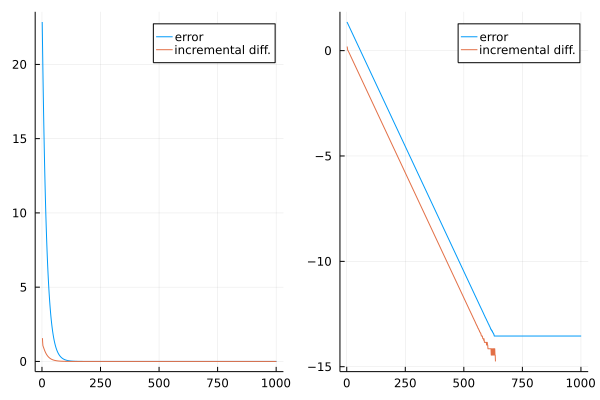

In [50]:
V = MDP.allocate_V(fmdp)
Q = MDP.allocate_Q(fmdp)
V[MDP.terminal_state(fmdp)] = 0

compute_Δ = V_ -> max.((abs.(V_ - V_uniform_random_policy))...)

iters_no = 1000

δ = zeros(iters_no+1)
Δ = zeros(iters_no+1)

δ[1] = NaN
Δ[1] = compute_Δ(V)

for i in 1:iters_no
    MDP.Q_from_V!(Q, V, fmdp, 1.0)
    δ[i+1] = MDP.V_from_Q!(V, Q, 𝐏)
    Δ[i+1] = compute_Δ(V)
end # for: iterations

Δ_textbook = copy(Δ)

l = @layout [a b]
p1 = plot(Δ, label="error")
plot!(δ, label="incremental diff.")
p2 = plot(log10.(Δ), label="error")
plot!(log10.(δ), label="incremental diff.")
plot(p1, p2, layout = l)


In [51]:
V_dp_random_policy = copy(V)
V_to_matrix_form(round.(V_dp_random_policy; digits=2))

4×4 Matrix{Float64}:
   0.0  -14.0  -20.0  -22.0
 -14.0  -18.0  -20.0  -20.0
 -20.0  -20.0  -18.0  -14.0
 -22.0  -20.0  -14.0    0.0

In [52]:
𝐩 = MDP.allocate_𝐩(Q)
MDP.𝐩_from_Q!(𝐩, Q)

𝐩_to_matrix_form(𝐩)

4×4 Matrix{Char}:
 '█'  '←'  '←'  '↓'
 '↑'  '←'  '↓'  '↓'
 '↑'  '↑'  '→'  '↓'
 '↑'  '→'  '→'  '█'

#### DP: Policy Evaluation using in-place update of V

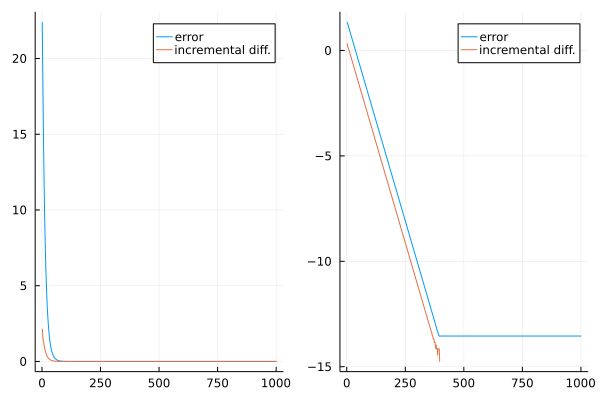

In [53]:
𝐏 = copy(uniform_random_policy)

V = MDP.allocate_V(fmdp)
Q = MDP.allocate_Q(fmdp)
V[MDP.terminal_state(fmdp)] = 0

compute_Δ = V_ -> max.((abs.(V_ - V_uniform_random_policy))...)

iters_no = 1000

δ = zeros(iters_no+1)
Δ = zeros(iters_no+1)

δ[1] = NaN
Δ[1] = compute_Δ(V)

for i in 1:iters_no
    MDP.Q_from_V!(Q, V, fmdp, 1.0)
    δ[i+1] = MDP.dp_update_V!(V, fmdp, 𝐏, 1.0)
    Δ[i+1] = compute_Δ(V)
end # for: iterations

Δ_Vinplace = copy(Δ)

l = @layout [a b]
p1 = plot(Δ, label="error")
plot!(δ, label="incremental diff.")
p2 = plot(log10.(Δ), label="error")
plot!(log10.(δ), label="incremental diff.")
plot(p1, p2, layout = l)

In [54]:
ndx = findfirst(δ .≤ 1e-4)
print("Achieved error = $(max(ΔV...)), after $(ndx-1) iterations.")

Achieved error = 0.0017198348138336428, after 115 iterations.

#### DP: Policy Evaluation - Comparison of different approaches

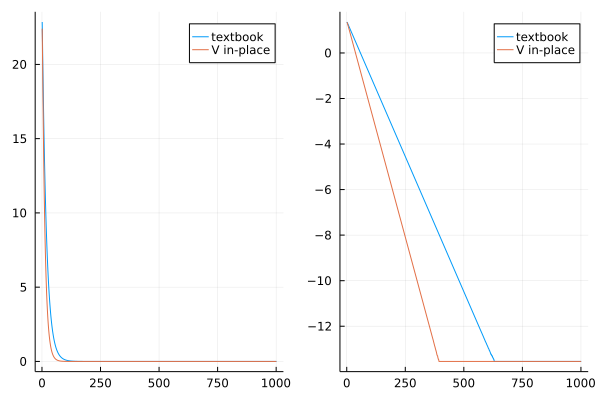

In [55]:
l = @layout [a b]
p1 = plot(Δ_textbook, label="textbook")
plot!(Δ_Vinplace, label="V in-place")
p2 = plot(log10.(Δ_textbook), label="textbook")
plot!(log10.(Δ_Vinplace), label="V in-place")
plot(p1, p2, layout = l)

### DP: Policy Optimization

#### DP: Policy Optimization using "textbook" **GPI**

In [56]:
function optimize_policy_textbook_GPI(; tol=1e-4, maxiter=5)
    𝐩 = copy(random_deterministic_policy)
    V = MDP.allocate_V(fmdp)
    Q = MDP.allocate_Q(fmdp)
    V[MDP.terminal_state(fmdp)] = 0
    converged = false
    iters_no = 1000
    for i = 1:1000
        MDP.dp_evaluate_policy_textbook!(V, Q, fmdp, 𝐩, 1.0; tol = tol, maxiter = maxiter)
        modified = MDP.𝐩_from_Q!(𝐩, Q)
        if !modified
            iters_no = i
            converged = true
            break
        end
    end # for: iterations
    return 𝐩, V, iters_no
end

optimize_policy_textbook_GPI (generic function with 1 method)

In [57]:
𝐩, V, iters_no = optimize_policy_textbook_GPI(tol=1e-12, maxiter=5)

ΔV = abs.((V - optimal_V))
err = max(ΔV...)

print("DP: policy optimization (textbook GPI): max abs err = $err (iters no = $iters_no)")
𝐩_to_matrix_form(𝐩)

DP: policy optimization (textbook GPI): max abs err = 0.0 (iters no = 4)

4×4 Matrix{Char}:
 '█'  '←'  '←'  '↓'
 '↑'  '↑'  '↑'  '↓'
 '↑'  '↑'  '↓'  '↓'
 '↑'  '→'  '→'  '█'

In [58]:
maxiter = [1, 5, 10, 20, 30, 50, 75, 100]
total_iter = NaN * ones(size(maxiter))

for (i, iter) in enumerate(maxiter)
    𝐩, V, iters_no = optimize_policy_textbook_GPI(tol=1e-12, maxiter=iter)

    total_iter[i] = iters_no * iter
    ΔV = abs.((V - optimal_V))
    err = max(ΔV...)
    println("DP: policy optimization (textbook GPI with maxiter=$iter): iters no = $iters_no (outer), $(iters_no * iter) (total)")
end

DP: policy optimization (textbook GPI with maxiter=1): iters no = 7 (outer), 7 (total)
DP: policy optimization (textbook GPI with maxiter=5): iters no = 4 (outer), 20 (total)
DP: policy optimization (textbook GPI with maxiter=10): iters no = 4 (outer), 40 (total)
DP: policy optimization (textbook GPI with maxiter=20): iters no = 4 (outer), 80 (total)
DP: policy optimization (textbook GPI with maxiter=30): iters no = 4 (outer), 120 (total)
DP: policy optimization (textbook GPI with maxiter=50): iters no = 4 (outer), 200 (total)
DP: policy optimization (textbook GPI with maxiter=75): iters no = 4 (outer), 300 (total)
DP: policy optimization (textbook GPI with maxiter=100): iters no = 4 (outer), 400 (total)


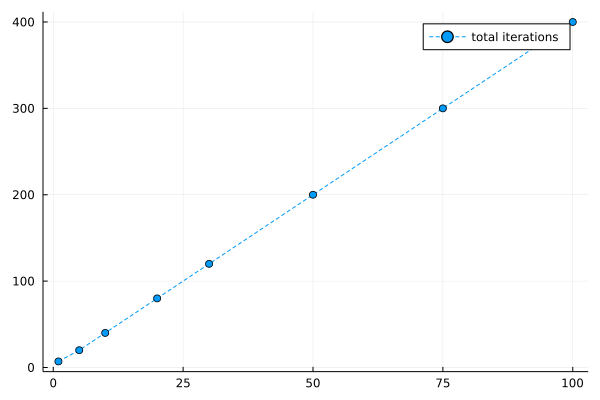

In [59]:
total_iter_textbook = total_iter
plot(maxiter, total_iter, linestyle=:dash, marker=:circle, label="total iterations")

#### DP: Policy Optimization using in-place update of V (Value Iteration)

In [60]:
function optimize_policy_V_inplace(; tol=1e-12, maxiter=1000)
    V = MDP.allocate_V(fmdp)
    V[MDP.terminal_state(fmdp)] = 0

    converged = false
    iters_no = maxiter
    for i = 1:maxiter
        Δ = MDP.dp_update_V!(V, fmdp, 1.0)
        if Δ < tol
            converged = true
            iters_no = i
            break
        end
    end

    return V, iters_no
end

optimize_policy_V_inplace (generic function with 1 method)

In [61]:
V, iters_no = optimize_policy_V_inplace(tol=1e-12, maxiter=1000)
ΔV = abs.((V - optimal_V))
err = max(ΔV...)
println("DP: policy optimization (value iteration): max abs err = $err (iters no = $iters_no)")

DP: policy optimization (value iteration): max abs err = 0.0 (iters no = 5)


## Monte Karlo

### MK: Baseline implementation

#### Baseline MK: Policy Evaluation

In [62]:
function evaluate_policy_MK(; maxiter = 10000)
    simulator = MDP.create_simulator_from_policy(fmdp, uniform_random_policy, 1000)

    V = MDP.allocate_V(fmdp)
    Q = MDP.allocate_Q(fmdp)

    MDP.mk_evaluate_policy!(Q, simulator, 1.0; maxiter = maxiter)

    MDP.V_from_Q!(V, Q, 𝐏)
    return V
end

function evaluate_policy_MK_repeated(; maxiter = 10000, n_attempts = 5, verbose = true)
    total_err = 0.0
    for _ in 1:n_attempts
        V = evaluate_policy_MK(maxiter = maxiter)
        ΔV = abs.(V - V_uniform_random_policy)
        err = max(ΔV...)
        if verbose
            println("MK: policy evaluation (maxiter = $maxiter): max abs err = $err")
        end
        total_err += err
    end
    total_err /= n_attempts
    return total_err
end

evaluate_policy_MK_repeated (generic function with 1 method)

In [63]:
total_err = evaluate_policy_MK_repeated(maxiter = 10000, n_attempts = 10, verbose = true)
println("---")
println("MK: policy evaluation: mean max abs err = $total_err")

MK: policy evaluation (maxiter = 10000): max abs err = 0.23962397053334783
MK: policy evaluation (maxiter = 10000): max abs err = 0.8338922630244809
MK: policy evaluation (maxiter = 10000): max abs err = 0.6195170422892744
MK: policy evaluation (maxiter = 10000): max abs err = 0.433216533033864
MK: policy evaluation (maxiter = 10000): max abs err = 0.7730854983458535
MK: policy evaluation (maxiter = 10000): max abs err = 0.6107445784300651
MK: policy evaluation (maxiter = 10000): max abs err = 0.5369124065700781
MK: policy evaluation (maxiter = 10000): max abs err = 0.739681025201989
MK: policy evaluation (maxiter = 10000): max abs err = 1.225281743293266
MK: policy evaluation (maxiter = 10000): max abs err = 0.8910211528262835
---
MK: policy evaluation: mean max abs err = 0.6902976213548502


In [64]:
maxiter = [1000, 5000, 10000, 25000, 50000, 100000]
mean_error = NaN*ones(size(maxiter))

for (i, iter) in enumerate(maxiter)
    mean_error[i] = evaluate_policy_MK_repeated(maxiter = iter, n_attempts = 5, verbose = false)
    println("MK: policy evaluation: mean max abs err after $iter iters. : $(mean_error[i])")
end

MK: policy evaluation: mean max abs err after 1000 iters. : 2.54678845104243
MK: policy evaluation: mean max abs err after 5000 iters. : 0.7233273844124106
MK: policy evaluation: mean max abs err after 10000 iters. : 0.5751507043721894
MK: policy evaluation: mean max abs err after 25000 iters. : 0.4351001948736887
MK: policy evaluation: mean max abs err after 50000 iters. : 0.2785480222188301
MK: policy evaluation: mean max abs err after 100000 iters. : 0.20040482496484593


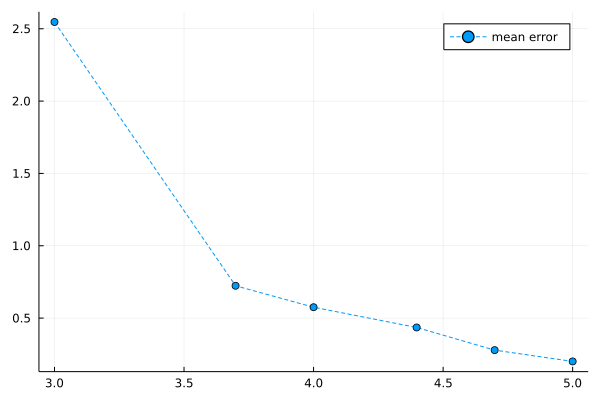

In [65]:
plot(log10.(maxiter), mean_error, linestyle=:dash, marker=:circle, label="mean error")

#### Baseline MK: Policy Optimization

In [66]:
𝐩 = copy(random_deterministic_policy)
simulator = MDP.create_simulator_from_policy(fmdp, 𝐩, 0.05, 100)

Q = MDP.allocate_Q(fmdp)
MDP.𝐩_from_Q!(𝐩, Q)

maxiter = 1000
iters_no = maxiter
for i = 1:maxiter
    MDP.mk_evaluate_policy!(Q, simulator, 1.0; maxiter = 10000)
    modified = MDP.𝐩_from_Q!(𝐩, Q)
    if !modified
        iters_no = i
        break
    end
end # for: iterations

V = MDP.allocate_V(fmdp)
MDP.V_from_Q!(V, Q, 𝐩)
ΔV = abs.(V - optimal_V)
err = max(ΔV...)
println("MK: policy optimization: max abs err = $err after $iters_no iterations.")

MK: policy optimization: max abs err = 0.1268742791234141 after 820 iterations.


In [67]:
Q

15×4 Matrix{Float64}:
 -2.0904   -3.10256  -3.19192  -1.0
 -3.13483  -4.1411   -4.2029   -2.07391
 -4.05143  -3.117    -4.1462   -3.14286
 -1.0      -3.17749  -3.13953  -2.06122
 -2.12865  -4.07212  -4.13636  -2.06236
 -3.1399   -3.12698  -3.23077  -3.12687
 -4.11735  -2.06831  -3.14894  -4.11173
 -2.06954  -4.15758  -4.12632  -3.15026
 -3.11934  -3.125    -3.12234  -3.13115
 -4.05946  -2.07609  -2.06448  -4.10674
 -3.15764  -1.0      -2.06842  -3.08743
 -3.11583  -4.19753  -3.16216  -4.13333
 -4.16374  -3.18182  -2.07816  -4.12575
 -3.15341  -2.10497  -1.0      -3.0929
  0.0       0.0       0.0       0.0

In [68]:
𝐩_to_matrix_form(𝐩)

4×4 Matrix{Char}:
 '█'  '←'  '←'  '↓'
 '↑'  '←'  '←'  '↓'
 '↑'  '↑'  '→'  '↓'
 '↑'  '→'  '→'  '█'

### MK: Incremental implementation

#### Incremental MK: Policy evaluation

In [69]:
𝐏 = copy(uniform_random_policy)
simulator = MDP.create_simulator_from_policy(fmdp, 𝐏, 1000)

V = MDP.allocate_V(fmdp)
Q = MDP.allocate_Q(fmdp)

ΔQ = -Inf
for _ = 1:10000
    ΔQ = MDP.mk_update_Q!(Q, 0.99, simulator, 1.0)
end

MDP.V_from_Q!(V, Q, 𝐏)
ΔV = abs.((V - V_uniform_random_policy))
err = max(ΔV...)
println("MK: policy evaluation (incremental): max abs err = $err (final ΔQ = $ΔQ)")

MK: policy evaluation (incremental): max abs err = 3.7336981077369273 (final ΔQ = 0.16873156669969802)

LoadError: InterruptException:

In [70]:
Q

15×4 Matrix{Float64}:
 -13.4096     -17.2737    -20.5515     -1.0
 -22.8773     -21.2295    -24.8349    -14.4482
 -25.8519     -24.3763    -24.5535    -22.7028
  -1.0        -17.413     -16.2272    -11.8282
 -13.4354     -17.7234    -19.2739    -12.668
 -20.9852     -19.6344    -20.8342    -17.3823
 -26.837      -16.2938    -25.5473    -20.3396
 -11.9496     -17.4947    -18.2448    -17.3761
 -15.6602     -17.9443    -16.6663    -16.8106
 -20.9749     -15.533     -15.826     -18.7277
 -22.5629      -1.0       -14.7003    -19.4592
 -17.5136     -19.4091    -16.8677    -19.8533
 -16.1311     -17.4748    -12.0528    -20.6034
 -19.7044     -15.0819     -1.0       -18.1338
   0.0537738    0.112917    0.150918    0.050116

In [71]:
MDP.V_from_Q!(V, Q, 𝐏)
V_to_matrix_form(round.(V; digits=2))

4×4 Matrix{Float64}:
   0.09  -13.06  -20.85  -24.37
 -11.62  -15.78  -19.71  -22.25
 -16.27  -16.77  -17.77  -14.43
 -18.41  -16.57  -13.48    0.09

#### Incremental MK: Policy Optimization

In [72]:
Q = MDP.allocate_Q(fmdp)
simulator = MDP.create_simulator_from_Q(fmdp, Q, 0.05, 1000)

ΔQ = -Inf
for i = 1:10000
    ΔQ = MDP.mk_update_Q!(Q, 0.95, simulator, 1.0)
end # for: iterations

V = MDP.allocate_V(fmdp)
MDP.V_from_Q!(V, Q)
ΔV = abs.(V - optimal_V)
err = max(ΔV...)
print("MK: policy optimization (incremental): max abs err = $err (final ΔQ = $ΔQ)")

MK: policy optimization (incremental): max abs err = 0.23492812345451686 (final ΔQ = 0.004186244798969341)

In [73]:
Q

15×4 Matrix{Float64}:
 -2.0552      -3.00501      -3.19301      -1.0
 -3.34378     -4.02956      -4.15135      -2.07724
 -4.15949     -3.23493      -4.16492      -3.26184
 -1.0         -3.00732      -3.25691      -2.04933
 -2.15092     -4.03146      -4.20356      -2.07724
 -3.13263     -3.23193      -3.0652       -3.17021
 -4.20987     -2.02929      -3.35903      -4.19258
 -2.12308     -4.08391      -4.20675      -3.2814
 -3.2257      -3.13508      -3.11532      -3.24061
 -4.12112     -2.19605      -2.07954      -4.27444
 -3.1939      -1.0          -2.00069      -3.02342
 -3.15345     -4.20881      -3.04234      -4.21513
 -4.0344      -3.08326      -2.08711      -4.10792
 -3.03526     -2.00541      -1.0          -3.24773
  9.53163e-5   0.000147754   0.000106995   5.65845e-5

In [74]:
𝐩 = MDP.allocate_𝐩(Q)
MDP.𝐩_from_Q!(𝐩, Q)
𝐩_to_matrix_form(𝐩)

4×4 Matrix{Char}:
 '█'  '←'  '←'  '↓'
 '↑'  '←'  '→'  '↓'
 '↑'  '→'  '→'  '↓'
 '→'  '→'  '→'  '█'

In [75]:
function optimize_policy_MK_incremental(; γ = 0.95, ε = 0.05)
    Q = MDP.allocate_Q(fmdp)
    simulator = MDP.create_simulator_from_Q(fmdp, Q, ε, 1000)

    𝐩 = MDP.allocate_𝐩(Q)

    ΔQ = -Inf
    maxiter = 10000
    iters_no = maxiter
    for i = 1:maxiter
        ΔQ = MDP.mk_update_Q!(Q, γ, simulator, 1.0)
        MDP.𝐩_from_Q!(𝐩, Q)
        #! It does NOT WORK if we only check whether policy is changed or not!
        if ΔQ < 1e-4
            iters_no = i
            break
        end
    end # for: iterations
    return iters_no, Q
end

optimize_policy_MK_incremental (generic function with 1 method)

In [76]:
iters_no, Q = optimize_policy_MK_incremental(γ = 0.95, ε = 0.05)

V = MDP.allocate_V(fmdp)
MDP.V_from_Q!(V, Q)
ΔV = abs.(V - optimal_V)
err = max(ΔV...)
print("MK: policy optimization (incremental): max abs err = $err (final ΔQ = $ΔQ) after $iters_no iters.")

MK: policy optimization (incremental): max abs err = 40.62127413158123 (final ΔQ = 0.004186244798969341) after 380 iters.

In [77]:
V_to_matrix_form(V)

4×4 Matrix{Float64}:
   0.488196   -0.740249  -19.9466   -41.5859
  -0.978356  -13.3804     -7.34471  -42.6213
 -41.6761     -3.26768    -4.60363   -0.943165
 -42.1359     -2.04898    -0.99986    0.488196

In [78]:
𝐩 = MDP.allocate_𝐩(Q)
MDP.𝐩_from_Q!(𝐩, Q)
𝐩_to_matrix_form(𝐩)

4×4 Matrix{Char}:
 '█'  '←'  '↓'  '↓'
 '↑'  '←'  '↓'  '↑'
 '↑'  '↓'  '←'  '↓'
 '→'  '→'  '→'  '█'

In [79]:
γ_array = [0.75, 0.9, 0.95, 0.99]

for γ in γ_array
    iters_no, Q = optimize_policy_MK_incremental(γ = γ, ε = 0.05)
    V = MDP.allocate_V(fmdp)
    MDP.V_from_Q!(V, Q)
    ΔV = abs.(V - optimal_V)
    err = max(ΔV...)
    println("MK: policy optimization (incremental γ = $γ): max abs err = $err after $iters_no iters.")
end

MK: policy optimization (incremental γ = 0.75): max abs err = 115.27157688398844 after 84 iters.
MK: policy optimization (incremental γ = 0.9): max abs err = 116.24490093987818 after 222 iters.
MK: policy optimization (incremental γ = 0.95): max abs err = 38.38929656534926 after 491 iters.
MK: policy optimization (incremental γ = 0.99): max abs err = 43.427181906696966 after 1636 iters.


In [80]:
𝐩 = MDP.allocate_𝐩(Q)
MDP.𝐩_from_Q!(𝐩, Q)
𝐩_to_matrix_form(𝐩)

4×4 Matrix{Char}:
 '█'  '←'  '←'  '↓'
 '↑'  '←'  '←'  '↓'
 '→'  '↓'  '→'  '↓'
 '↑'  '→'  '→'  '█'

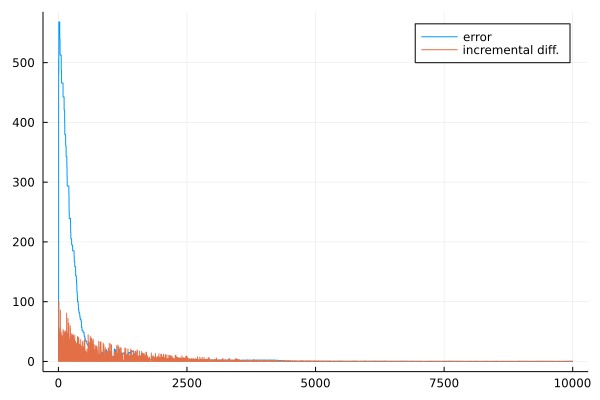

In [81]:
V = MDP.allocate_V(fmdp)
Q = MDP.allocate_Q(fmdp)
V[MDP.terminal_state(fmdp)] = 0

compute_Δ = V_ -> max.((abs.(V_ - optimal_V))...)

simulator = MDP.create_simulator_from_Q(fmdp, Q, 0.05, 1000)

maxiter = 10000
iters_no = maxiter

δ = zeros(iters_no+1)
Δ = zeros(iters_no+1)

δ[1] = NaN
Δ[1] = compute_Δ(V)

for i in 1:maxiter
    δ[i+1] = MDP.mk_update_Q!(Q, 0.95, simulator, 1.0)
    MDP.V_from_Q!(V, Q)
    Δ[i+1] = compute_Δ(V)
end # for: iterations

plot(Δ, label="error")
plot!(δ, label="incremental diff.")

In [82]:
𝐩 = MDP.allocate_𝐩(Q)
MDP.𝐩_from_Q!(𝐩, Q)
𝐩_to_matrix_form(𝐩)

4×4 Matrix{Char}:
 '█'  '←'  '←'  '←'
 '↑'  '←'  '↑'  '↓'
 '↑'  '↓'  '↓'  '↓'
 '↑'  '→'  '→'  '█'